In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys
import matplotlib.pyplot as plt
import my_python_package as mpp
from collections import OrderedDict as od
from pyhalofit import pyhalofit
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d
from time import time
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /Users/sugiyamasunao/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


### pyhalofit high zで合わない？
gglensing解析の時は$z<0.7$程度までしかCAMBとの一位度のテストはしなかった。
しかし、z>1について調べると、CAMBのtakahashi halofitと合わない。

## pyhalofit

In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
%%time
power_b1.init_pklin(4.0, kmax=1e2)

CPU times: user 88.6 ms, sys: 1.9 ms, total: 90.5 ms
Wall time: 23.2 ms


In [5]:
%%time
power_b1.init_pkhalo()

CPU times: user 452 ms, sys: 7.25 ms, total: 460 ms
Wall time: 194 ms


In [6]:
cosmo_dict = power_b1.get_cosmo_dict()

### CAMB

In [7]:
import camb
from camb.dark_energy import DarkEnergyPPF

In [8]:
pars = camb.CAMBparams()
h = cosmo_dict['h']
pars.set_cosmology(H0=100*cosmo_dict['h'], 
                   ombh2=cosmo_dict['omega_b'], 
                   omch2=cosmo_dict['omega_c'], mnu=0.06)
As = np.exp(cosmo_dict['ln10p10As'])*1e-10
pars.InitPower.set_params(ns=cosmo_dict['n_s'],As=As)
pars.DarkEnergy = DarkEnergyPPF(w=cosmo_dict['w_de'], wa=0.0)

redshifts = power_b1.pk_data['z']

pars.set_matter_power(redshifts=redshifts, kmax=2.0)
pars.NonLinearModel.set_params(halofit_version='takahashi')

results = camb.get_results(pars)
kh_nonlin, _, pk_takahashi = results.get_nonlinear_matter_power_spectrum(params=pars)
kh, _, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)
#pk_takahashi = pk_takahashi[::-1]

Note: redshifts have been re-sorted (earliest first)


In [9]:
len(redshifts)

100

2.4242424242424243


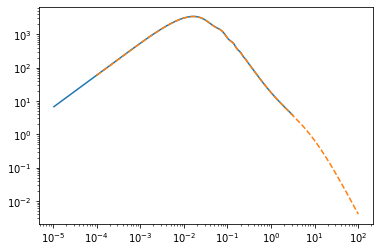

In [11]:
i = 60
print(redshifts[i])
plt.figure()
#for i, redshift in enumerate(redshifts[:1]):
plt.loglog(kh_nonlin, pk_takahashi[i, :])
    
k = 10**power_b1.pk_data['logk']
#for pkhalo in power_b1.pk_data['pkhalo'][:1]:
pkhalo = power_b1.pk_data['pkhalo'][i,:]
plt.loglog(k, pkhalo, ls='--')
    
plt.show()

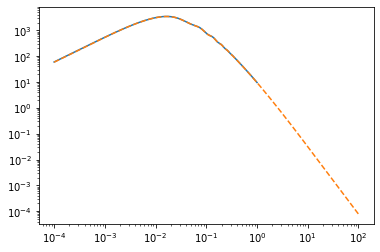

In [12]:
plt.figure()
#for i, redshift in enumerate(redshifts[:1]):
plt.loglog(kh, pk[i, :])
    
k = 10**power_b1.pk_data['logk']
#for Dp in power_b1.pk_data['Dp'][:1]:
Dp = power_b1.pk_data['Dp'][i]
plt.loglog(k, power_b1.pk_data['pkL']*Dp**2, ls='--')
    
plt.show()

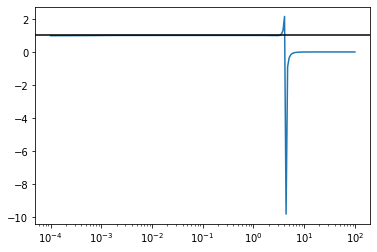

In [13]:
plt.figure()

k = 10**power_b1.pk_data['logk']
#for i, pkhalo in enumerate(power_b1.pk_data['pkhalo'][:1]):
pkhalo = power_b1.pk_data['pkhalo'][i,:]
p = ius(kh_nonlin, pk_takahashi[i, :])(k)
plt.semilogx(k, pkhalo/p, ls='-')
    
plt.axhline(1.0, color='k')
plt.show()

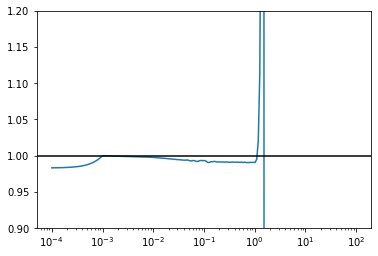

In [14]:
plt.figure()
    
k = 10**power_b1.pk_data['logk']
#for i, Dp in enumerate(power_b1.pk_data['Dp'][:1]):
Dp = power_b1.pk_data['Dp'][i]
p = ius(kh, pk[i, :])(k)
plt.semilogx(k, power_b1.pk_data['pkL']*Dp**2/p, ls='-')
    
plt.ylim(0.9, 1.2)
plt.axhline(1.0, color='k')
plt.show()

## conclusion
$\sigma(R)$を計算するところを間違えるらしい。
pklinをsamplingするときにhigh kまでとるとsigma(R)の評価、すなわちsigma(R_sigma)=1の評価が正しくなる。CAMBの値に等しくなる。


In [14]:
k = 10**power_b1.pk_data['logk']
pkL = power_b1.pk_data['pkL']

sigmaR = []
for _z, _Dp in zip(power_b1.pk_data['z'], power_b1.pk_data['Dp']):
    pklin = pkL*_Dp**2
    power_b1.halofit.set_pklin(k, pklin, _z)
    s = power_b1.halofit.sigma(0.0)
    sigmaR.append(s)
sigmaR = np.array(sigmaR)

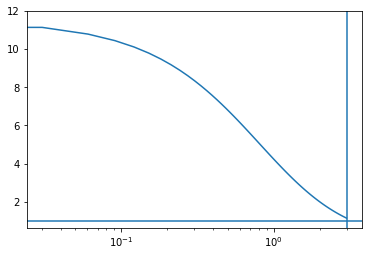

In [15]:
plt.figure()
plt.semilogx(power_b1.pk_data['z'], sigmaR)
plt.axhline(1.0)
plt.axvline(3.0)
plt.show()

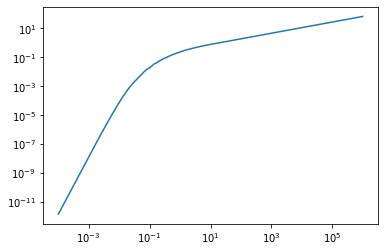

166.2893699873815
0.6247731292396285


In [22]:
k = np.logspace(-4, 6, 1000)
pkL = power_b1.pkL.get(k)

z = 4.0
Dp = power_b1.get_Dgrowth(z)


Delta_L = pkL*Dp**2*k**3/(2*np.pi**2)


R=0
plt.figure()
plt.loglog(k, Delta_L)
plt.show()

k_sigma = 10.**(-1.065+4.332e-1*(1.+z)-2.516e-2*pow(1.+z,2)+9.069e-4*pow(1.+z,3))

s = simps(Delta_L*np.exp(-(k*R)**2), np.log(k))
print(s)

R = 1.0/k_sigma
s = simps(Delta_L*np.exp(-(k*R)**2), np.log(k))
print(s)

In [23]:

from scipy.optimize import fsolve

In [24]:
k_sigma = 10.**(-1.065+4.332e-1*(1.+z)-2.516e-2*pow(1.+z,2)+9.069e-4*pow(1.+z,3))

def sigma(R):
    return simps(Delta_L*np.exp(-(k*R)**2), np.log(k))

def eq(R):
    return sigma(R) - 1.0
        
R_sigma = abs(fsolve(eq, [1./k_sigma]))

In [26]:
R_sigma

array([0.12773174])

In [27]:
sigma(R_sigma)

0.9999999999999999